In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn # for train_test_split, metrics
import warnings
warnings.filterwarnings('ignore')
import librosa
import librosa.display
import joblib   # For saving label encoders

# Deep Learning specific imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- DEFINE YOUR PATHS HERE ---

COMMON_VOICE_DATASET_ROOT = "/kaggle/input/common-voice/"

# Paths for metadata CSVs (these are directly inside the dataset root)
COMMON_VOICE_METADATA_TRAIN_CSV = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-train.csv")
COMMON_VOICE_METADATA_TEST_CSV = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-test.csv")

# Paths to the ACTUAL AUDIO FILES DIRECTORIES within their respective splits
# Based on your ls output, the mp3s are in a nested folder with the same name.
ACTUAL_AUDIO_TRAIN_CLIPS_PATH = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-train", "cv-valid-train")
ACTUAL_AUDIO_TEST_CLIPS_PATH = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-test", "cv-valid-test")

# Path for saving new DL models and transformers
MODEL_SAVE_DL_PATH = "/kaggle/working/"
if not os.path.exists(MODEL_SAVE_DL_PATH):
    os.makedirs(MODEL_SAVE_DL_PATH)

# --- Verification ---
print(f"Dataset Root Path: {COMMON_VOICE_DATASET_ROOT}")
print(f"Training Metadata CSV: {COMMON_VOICE_METADATA_TRAIN_CSV} - Exists: {os.path.exists(COMMON_VOICE_METADATA_TRAIN_CSV)}")
print(f"Test Metadata CSV: {COMMON_VOICE_METADATA_TEST_CSV} - Exists: {os.path.exists(COMMON_VOICE_METADATA_TEST_CSV)}")
print(f"Actual Training Audio Clips Path: {ACTUAL_AUDIO_TRAIN_CLIPS_PATH} - Exists: {os.path.exists(ACTUAL_AUDIO_TRAIN_CLIPS_PATH)}")
print(f"Actual Test Audio Clips Path: {ACTUAL_AUDIO_TEST_CLIPS_PATH} - Exists: {os.path.exists(ACTUAL_AUDIO_TEST_CLIPS_PATH)}")

if os.path.exists(ACTUAL_AUDIO_TRAIN_CLIPS_PATH) and os.path.isdir(ACTUAL_AUDIO_TRAIN_CLIPS_PATH):
    print(f"  First 5 items in {ACTUAL_AUDIO_TRAIN_CLIPS_PATH}: {os.listdir(ACTUAL_AUDIO_TRAIN_CLIPS_PATH)[:5]}")
else:
    print(f"WARNING: Training audio clips directory NOT FOUND or is not a directory: {ACTUAL_AUDIO_TRAIN_CLIPS_PATH}")

if os.path.exists(ACTUAL_AUDIO_TEST_CLIPS_PATH) and os.path.isdir(ACTUAL_AUDIO_TEST_CLIPS_PATH):
    print(f"  First 5 items in {ACTUAL_AUDIO_TEST_CLIPS_PATH}: {os.listdir(ACTUAL_AUDIO_TEST_CLIPS_PATH)[:5]}")
else:
    print(f"WARNING: Test audio clips directory NOT FOUND or is not a directory: {ACTUAL_AUDIO_TEST_CLIPS_PATH}")

2025-05-18 05:42:16.216125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747546936.486469      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747546936.569379      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset Root Path: /kaggle/input/common-voice/
Training Metadata CSV: /kaggle/input/common-voice/cv-valid-train.csv - Exists: True
Test Metadata CSV: /kaggle/input/common-voice/cv-valid-test.csv - Exists: True
Actual Training Audio Clips Path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train - Exists: True
Actual Test Audio Clips Path: /kaggle/input/common-voice/cv-valid-test/cv-valid-test - Exists: True
  First 5 items in /kaggle/input/common-voice/cv-valid-train/cv-valid-train: ['sample-190523.mp3', 'sample-134671.mp3', 'sample-136900.mp3', 'sample-087521.mp3', 'sample-141316.mp3']
  First 5 items in /kaggle/input/common-voice/cv-valid-test/cv-valid-test: ['sample-000422.mp3', 'sample-000497.mp3', 'sample-000446.mp3', 'sample-000912.mp3', 'sample-001249.mp3']


In [3]:
def load_and_clean_metadata(csv_path, base_dataset_root_path_for_csv_relative_paths):
    """
    Loads and cleans metadata, adding a column with the full path to audio files.
    csv_path: Path to the metadata CSV file (e.g., /kaggle/input/common-voice/cv-valid-train.csv).
    base_dataset_root_path_for_csv_relative_paths: The root path of the dataset where the 'filename' column's
                                                   relative paths start from (e.g., /kaggle/input/common-voice/).
    """
    try:
        df_meta = pd.read_csv(csv_path)
        print(f"\nLoaded {os.path.basename(csv_path)} with shape: {df_meta.shape}")
    except FileNotFoundError:
        print(f"ERROR: CSV file not found at {csv_path}.")
        return pd.DataFrame()

    df_meta_cleaned = df_meta[['filename', 'age', 'gender']].copy()
    df_meta_cleaned.dropna(subset=['age', 'gender'], inplace=True)

    df_meta_cleaned['gender_numeric'] = df_meta_cleaned['gender'].map({'female': 0, 'male': 1})
    df_meta_cleaned.dropna(subset=['gender_numeric'], inplace=True)
    df_meta_cleaned['gender_numeric'] = df_meta_cleaned['gender_numeric'].astype(int)

    # --- Construct full filepath FOR LOADING and VALIDATION (os.path.exists) ---
    def construct_actual_path(csv_filename_entry):
        # csv_filename_entry is like 'cv-valid-train/sample-000005.mp3'
        parts = csv_filename_entry.split('/') # ['cv-valid-train', 'sample-000005.mp3']
        if len(parts) == 2:
            # Reconstruct the path: root/folder_name_from_csv/folder_name_from_csv_again/mp3_filename
            # This corresponds to ACTUAL_AUDIO_TRAIN_CLIPS_PATH or ACTUAL_AUDIO_TEST_CLIPS_PATH structure
            # Example: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3
            return os.path.join(base_dataset_root_path_for_csv_relative_paths, parts[0], parts[0], parts[1])
        # Fallback for unexpected format, though less likely given current understanding
        return os.path.join(base_dataset_root_path_for_csv_relative_paths, csv_filename_entry)

    df_meta_cleaned['full_audio_path'] = df_meta_cleaned['filename'].apply(
        lambda x: construct_actual_path(x)
    )
    
    print(f"Debugging filepaths for {os.path.basename(csv_path)} (for validation and loading):")
    if not df_meta_cleaned.empty:
        for i in range(min(3, len(df_meta_cleaned))):
            fp_to_check = df_meta_cleaned['full_audio_path'].iloc[i]
            csv_filename_entry = df_meta_cleaned['filename'].iloc[i]
            print(f"  CSV filename: {csv_filename_entry} -> Constructed full_audio_path: {fp_to_check} - Exists: {os.path.exists(fp_to_check)}")
    else:
        print("  DataFrame is empty before path validation.")

    original_count = len(df_meta_cleaned)
    # Validate existence using the newly created 'full_audio_path'
    df_meta_cleaned = df_meta_cleaned[df_meta_cleaned['full_audio_path'].apply(os.path.exists)].copy()
    validated_count = len(df_meta_cleaned)
    
    print(f"Path validation: {validated_count} files found out of {original_count} initially cleaned entries for {os.path.basename(csv_path)}.")
    if validated_count == 0 and original_count > 0:
        print(f"WARNING: No audio files were found for {os.path.basename(csv_path)} using the path construction logic.")

    print(f"Shape after cleaning and path validation for {os.path.basename(csv_path)}: {df_meta_cleaned.shape}")
    
    # Return the essential columns including the full_audio_path
    return df_meta_cleaned[['filename', 'age', 'gender', 'gender_numeric', 'full_audio_path']].reset_index(drop=True)

# COMMON_VOICE_DATASET_ROOT is defined in Cell 1
df_train_val = load_and_clean_metadata(COMMON_VOICE_METADATA_TRAIN_CSV, 
                                       base_dataset_root_path_for_csv_relative_paths=COMMON_VOICE_DATASET_ROOT)

df_test = load_and_clean_metadata(COMMON_VOICE_METADATA_TEST_CSV, 
                                  base_dataset_root_path_for_csv_relative_paths=COMMON_VOICE_DATASET_ROOT)

print("\nTraining/Validation Data Head (if populated):")
if not df_train_val.empty:
    print(df_train_val.head())
else:
    print("df_train_val is empty.")

print("\nTest Data Head (if populated):")
if not df_test.empty:
    print(df_test.head())
else:
    print("df_test is empty.")


Loaded cv-valid-train.csv with shape: (195776, 8)
Debugging filepaths for cv-valid-train.csv (for validation and loading):
  CSV filename: cv-valid-train/sample-000005.mp3 -> Constructed full_audio_path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3 - Exists: True
  CSV filename: cv-valid-train/sample-000008.mp3 -> Constructed full_audio_path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000008.mp3 - Exists: True
  CSV filename: cv-valid-train/sample-000013.mp3 -> Constructed full_audio_path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000013.mp3 - Exists: True
Path validation: 72692 files found out of 72692 initially cleaned entries for cv-valid-train.csv.
Shape after cleaning and path validation for cv-valid-train.csv: (72692, 5)

Loaded cv-valid-test.csv with shape: (3995, 8)
Debugging filepaths for cv-valid-test.csv (for validation and loading):
  CSV filename: cv-valid-test/sample-000001.mp3 -> Constructed full_a

In [4]:
if not df_train_val.empty:
    age_encoder = LabelEncoder()
    df_train_val['age_encoded'] = age_encoder.fit_transform(df_train_val['age'])
    age_classes = age_encoder.classes_
    num_age_classes = len(age_classes)
    print("Age Classes:", age_classes)
    print("Number of Age Classes:", num_age_classes)
    joblib.dump(age_encoder, os.path.join(MODEL_SAVE_DL_PATH, 'dl_age_label_encoder.pkl'))

    if not df_test.empty:
        # Important: Use the *fitted* encoder from training data to transform test data
        # Handle unseen labels in test data by ignoring them or mapping to a special category
        df_test['age_encoded'] = df_test['age'].apply(lambda x: age_encoder.transform([x])[0] if x in age_encoder.classes_ else -1) # -1 for unknown
        df_test = df_test[df_test['age_encoded'] != -1].copy() # Remove rows with unknown age labels for evaluation
        print(f"Test data shape after age encoding and filtering unknowns: {df_test.shape}")

else:
    print("df_train_val is empty. Cannot perform label encoding.")

Age Classes: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']
Number of Age Classes: 8
Test data shape after age encoding and filtering unknowns: (1523, 6)


Attempting to generate spectrogram for: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3


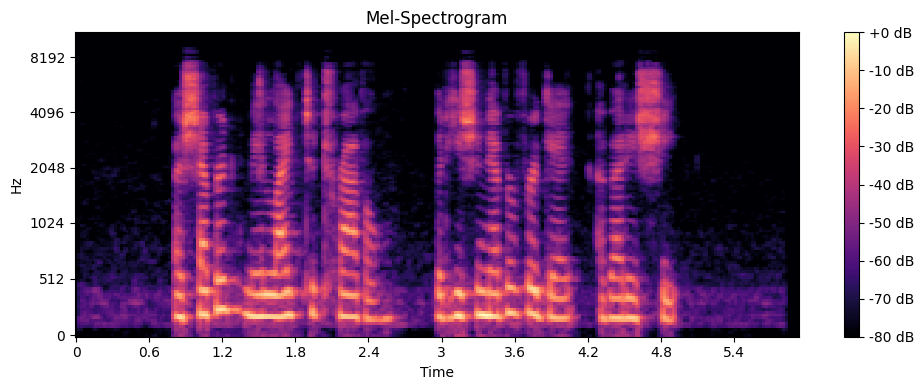

Spectrogram shape: (128, 256)


In [5]:
# Parameters for spectrogram
SR = 22050  # Sampling rate (librosa default, can be tuned)
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Hop length for STFT
N_MELS = 128  # Number of Mel bands
MAX_FRAMES = 256 # Max frames to ensure fixed size input for CNN (needs tuning based on audio length)

def audio_to_melspectrogram(filepath, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, max_frames=MAX_FRAMES):
    try:
        audio, _ = librosa.load(filepath, sr=sr)
        # Pad or truncate audio to a fixed length if necessary before spectrogram
        # fixed_length = sr * 5 # e.g., 5 seconds
        # if len(audio) < fixed_length:
        #     audio = np.pad(audio, (0, fixed_length - len(audio)), mode='constant')
        # else:
        #     audio = audio[:fixed_length]

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate the spectrogram to a fixed width (time frames)
        if log_mel_spec.shape[1] < max_frames:
            pad_width = max_frames - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=-80) # Pad with silence (low dB)
        else:
            log_mel_spec = log_mel_spec[:, :max_frames]

        return log_mel_spec
    except Exception as e:
        print(f"Error generating spectrogram for {filepath}: {e}")
        return None

# Test spectrogram generation
if not df_train_val.empty:
    # Use the 'full_audio_path' column added in Cell 2
    sample_audio_file = df_train_val.iloc[0]['full_audio_path']
    print(f"Attempting to generate spectrogram for: {sample_audio_file}")
    sample_spec = audio_to_melspectrogram(sample_audio_file)
    if sample_spec is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(sample_spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.tight_layout()
        plt.show()
        print("Spectrogram shape:", sample_spec.shape) # Should be (N_MELS, MAX_FRAMES)
    else:
        print(f"Failed to generate spectrogram for {sample_audio_file}")
else:
    print("df_train_val is empty. Cannot test spectrogram generation.")

In [6]:
class AudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, audio_path_col, label_col_age, label_col_gender,
                 batch_size, n_mels, max_frames, num_age_classes,
                 shuffle=True, is_training=True, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH):
        self.df = df.copy()
        self.audio_path_col = audio_path_col
        self.label_col_age = label_col_age
        self.label_col_gender = label_col_gender # gender_numeric
        self.batch_size = batch_size
        self.n_mels = n_mels
        self.max_frames = max_frames
        self.num_age_classes = num_age_classes
        self.shuffle = shuffle
        self.is_training = is_training # To control augmentation or specific processing
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        df_batch = self.df.iloc[batch_indexes]

        # Generate data
        X_spectrograms = self._generate_X(df_batch)
        y_age_batch = self._generate_y_age(df_batch)
        y_gender_batch = self._generate_y_gender(df_batch)
        
        # Return as a dictionary if you have multiple outputs for your model
        # For separate models, you'll create separate generators or adapt this
        return X_spectrograms, {'age_output': y_age_batch, 'gender_output': y_gender_batch}


    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_X(self, df_batch):
        # Generates data containing batch_size samples
        X = np.empty((self.batch_size, self.n_mels, self.max_frames, 1)) # Add channel dimension for CNN

        for i, (_, row) in enumerate(df_batch.iterrows()):
            filepath = row[self.audio_path_col]
            mel_spec = audio_to_melspectrogram(filepath, sr=self.sr, n_fft=self.n_fft,
                                               hop_length=self.hop_length, n_mels=self.n_mels,
                                               max_frames=self.max_frames)
            if mel_spec is not None:
                X[i,] = np.expand_dims(mel_spec, axis=-1) # Add channel dim
            else: # Handle error: use a zero spectrogram or skip
                X[i,] = np.zeros((self.n_mels, self.max_frames, 1))
        return X

    def _generate_y_age(self, df_batch):
        y_age = np.empty((self.batch_size, self.num_age_classes), dtype=int) # One-hot for age
        for i, (_, row) in enumerate(df_batch.iterrows()):
            age_encoded = row[self.label_col_age]
            y_age[i,] = to_categorical(age_encoded, num_classes=self.num_age_classes)
        return y_age

    def _generate_y_gender(self, df_batch):
        y_gender = np.empty((self.batch_size, 1), dtype=int) # Binary for gender (0 or 1)
        for i, (_, row) in enumerate(df_batch.iterrows()):
            y_gender[i,] = row[self.label_col_gender]
        return y_gender

# Example: Split train_val into train and validation for DL
if not df_train_val.empty:
    train_df, val_df = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=df_train_val['age_encoded'])
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # Create a generator instance (this is for a multi-output model structure)
    # For separate models, you'd call this with only one label_col active or create two generators
    # train_generator_example = AudioDataGenerator(train_df,
    #                                        audio_path_col='filepath',
    #                                        label_col_age='age_encoded',
    #                                        label_col_gender='gender_numeric',
    #                                        batch_size=32,
    #                                        n_mels=N_MELS,
    #                                        max_frames=MAX_FRAMES,
    #                                        num_age_classes=num_age_classes)
    # x_batch_example, y_batch_example_dict = train_generator_example[0]
    # print("Shape of X batch:", x_batch_example.shape)
    # print("Shape of y_age batch:", y_batch_example_dict['age_output'].shape)
    # print("Shape of y_gender batch:", y_batch_example_dict['gender_output'].shape)
else:
    print("df_train_val is empty. Cannot create data generators.")

Training samples: 58153, Validation samples: 14539


In [7]:
# --- AGE PREDICTION MODEL ---
def create_age_model(input_shape, num_age_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_age_classes, activation='softmax', name='age_output') # Softmax for multi-class age
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- GENDER PREDICTION MODEL ---
def create_gender_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid', name='gender_output') # Sigmoid for binary gender
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape for the models
if 'sample_spec' in globals() and sample_spec is not None:
    INPUT_SHAPE_SPECTROGRAM = (N_MELS, MAX_FRAMES, 1) # (height, width, channels)

    age_model_cnn = create_age_model(INPUT_SHAPE_SPECTROGRAM, num_age_classes)
    print("Age Model Summary:")
    age_model_cnn.summary()

    gender_model_cnn = create_gender_model(INPUT_SHAPE_SPECTROGRAM)
    print("\nGender Model Summary:")
    gender_model_cnn.summary()
else:
    print("sample_spec not generated, cannot define model input shape.")

2025-05-18 05:49:57.218614: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Age Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 128, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ age_output (Dense)                   │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,874,120 (64.37 MB)

 Trainable params: 16,873,160 (64.37 MB)

 Non-trainable params: 960 (3.75 KB)


Gender Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 128, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gender_output (Dense)                │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,797,185 (64.08 MB)

 Trainable params: 16,796,737 (64.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
class SingleTaskAudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, audio_path_col, label_col,
                 batch_size, n_mels, max_frames,
                 num_classes=None, # For categorical (age)
                 is_categorical_label=False, # True for age, False for gender
                 shuffle=True, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH):
        self.df = df.copy()
        self.audio_path_col = audio_path_col # This will be 'full_audio_path'
        self.label_col = label_col
        self.batch_size = batch_size
        self.n_mels = n_mels
        self.max_frames = max_frames
        self.num_classes = num_classes
        self.is_categorical_label = is_categorical_label
        self.shuffle = shuffle
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # Ensure at least one full batch can be formed
        if len(self.df) < self.batch_size:
             # print(f"Warning: DataFrame length ({len(self.df)}) is less than batch_size ({self.batch_size}). Generator will produce 0 batches.")
             return 0
        return int(np.floor(len(self.df) / self.batch_size))


    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        df_batch = self.df.iloc[batch_indexes]
        X = self._generate_X(df_batch)
        y = self._generate_y(df_batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_X(self, df_batch):
        X = np.empty((self.batch_size, self.n_mels, self.max_frames, 1))
        for i, (_, row) in enumerate(df_batch.iterrows()):
            filepath = row[self.audio_path_col] # This will use 'full_audio_path'
            mel_spec = audio_to_melspectrogram(filepath, sr=self.sr, n_fft=self.n_fft,
                                               hop_length=self.hop_length, n_mels=self.n_mels,
                                               max_frames=self.max_frames)
            if mel_spec is not None:
                X[i,] = np.expand_dims(mel_spec, axis=-1)
            else:
                X[i,] = np.zeros((self.n_mels, self.max_frames, 1)) # Default on error
        return X

    def _generate_y(self, df_batch):
        if self.is_categorical_label:
            y = np.empty((self.batch_size, self.num_classes), dtype=int)
            for i, (_, row) in enumerate(df_batch.iterrows()):
                label_encoded = row[self.label_col]
                y[i,] = to_categorical(label_encoded, num_classes=self.num_classes)
        else: # Binary label (gender)
            y = np.empty((self.batch_size, 1), dtype=int)
            for i, (_, row) in enumerate(df_batch.iterrows()):
                y[i,] = row[self.label_col]
        return y

BATCH_SIZE = 32 # Can be tuned

# Ensure train_df and val_df are defined from Cell 5 and num_age_classes from Cell 3
if 'train_df' in globals() and 'val_df' in globals() and not train_df.empty and not val_df.empty and 'num_age_classes' in globals():
    # Generator for Age
    train_age_gen = SingleTaskAudioDataGenerator(train_df, 'full_audio_path', 'age_encoded', BATCH_SIZE, N_MELS, MAX_FRAMES, num_age_classes, is_categorical_label=True)
    val_age_gen = SingleTaskAudioDataGenerator(val_df, 'full_audio_path', 'age_encoded', BATCH_SIZE, N_MELS, MAX_FRAMES, num_age_classes, is_categorical_label=True, shuffle=False)

    # Generator for Gender
    train_gender_gen = SingleTaskAudioDataGenerator(train_df, 'full_audio_path', 'gender_numeric', BATCH_SIZE, N_MELS, MAX_FRAMES, is_categorical_label=False)
    val_gender_gen = SingleTaskAudioDataGenerator(val_df, 'full_audio_path', 'gender_numeric', BATCH_SIZE, N_MELS, MAX_FRAMES, is_categorical_label=False, shuffle=False)
    print("Single-task data generators created.")
    
    # Optional: Check if generators can produce batches
    if len(train_age_gen) == 0:
        print(f"Warning: train_age_gen will produce 0 batches. Train df size: {len(train_df)}, Batch size: {BATCH_SIZE}")
    if len(val_age_gen) == 0:
        print(f"Warning: val_age_gen will produce 0 batches. Val df size: {len(val_df)}, Batch size: {BATCH_SIZE}")

else:
    if 'train_df' not in globals() or 'val_df' not in globals():
        print("train_df or val_df is not defined. Cannot create generators. (Did Cell 5 run correctly?)")
    elif 'num_age_classes' not in globals():
        print("num_age_classes is not defined. Cannot create age generators. (Did Cell 3 run correctly?)")
    else:
        print("train_df or val_df is empty. Cannot create generators.")

Single-task data generators created.


In [ ]:
EPOCHS_AGE = 20 # Start with fewer epochs for testing, e.g., 10-20
if 'age_model_cnn' in globals() and not train_df.empty and not val_df.empty:
    age_checkpoint_path = os.path.join(MODEL_SAVE_DL_PATH, "best_age_model_cnn.h5")
    age_checkpoint = ModelCheckpoint(age_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    age_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
    age_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

    print("\n--- Training Age Model ---")
    history_age = age_model_cnn.fit(
        train_age_gen,
        validation_data=val_age_gen,
        epochs=EPOCHS_AGE,
        callbacks=[age_checkpoint, age_early_stopping, age_reduce_lr]
    )

    # Plot training history for age
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_age.history['accuracy'], label='Train Accuracy')
    plt.plot(history_age.history['val_accuracy'], label='Val Accuracy')
    plt.title('Age Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history_age.history['loss'], label='Train Loss')
    plt.plot(history_age.history['val_loss'], label='Val Loss')
    plt.title('Age Model Loss')
    plt.legend()
    plt.show()

    # Load best weights
    age_model_cnn.load_weights(age_checkpoint_path)
else:
    print("Age model or data generators not ready for training.")


--- Training Age Model ---
Epoch 1/20
 196/1817 ━━━━━━━━━━━━━━━━━━━━ 1:14:26 3s/step - accuracy: 0.2069 - loss: 2.4260

In [ ]:
EPOCHS_GENDER = 15 # Start with fewer epochs
if 'gender_model_cnn' in globals() and not train_df.empty and not val_df.empty:
    gender_checkpoint_path = os.path.join(MODEL_SAVE_DL_PATH, "best_gender_model_cnn.h5")
    gender_checkpoint = ModelCheckpoint(gender_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    gender_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
    gender_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

    print("\n--- Training Gender Model ---")
    history_gender = gender_model_cnn.fit(
        train_gender_gen,
        validation_data=val_gender_gen,
        epochs=EPOCHS_GENDER,
        callbacks=[gender_checkpoint, gender_early_stopping, gender_reduce_lr]
    )

    # Plot training history for gender
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_gender.history['accuracy'], label='Train Accuracy')
    plt.plot(history_gender.history['val_accuracy'], label='Val Accuracy')
    plt.title('Gender Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history_gender.history['loss'], label='Train Loss')
    plt.plot(history_gender.history['val_loss'], label='Val Loss')
    plt.title('Gender Model Loss')
    plt.legend()
    plt.show()
    
    # Load best weights
    gender_model_cnn.load_weights(gender_checkpoint_path)
else:
    print("Gender model or data generators not ready for training.")

In [ ]:
# Load models if not already loaded (e.g., in a new session)
# Ensure MODEL_SAVE_DL_PATH is defined (Cell 1)
# Ensure dl_age_label_encoder.pkl was saved (Cell 3)
age_model_path = os.path.join(MODEL_SAVE_DL_PATH, "best_age_model_cnn.keras")
gender_model_path = os.path.join(MODEL_SAVE_DL_PATH, "best_gender_model_cnn.keras")
age_encoder_path = os.path.join(MODEL_SAVE_DL_PATH, 'dl_age_label_encoder.pkl')

dl_models_loaded_for_pred = False
loaded_age_model_cnn = None
loaded_gender_model_cnn = None
loaded_age_label_encoder_dl = None

try:
    if os.path.exists(age_model_path):
        loaded_age_model_cnn = tf.keras.models.load_model(age_model_path)
        print("Loaded age model from:", age_model_path)
    else:
        print(f"Age model file not found at: {age_model_path}")

    if os.path.exists(gender_model_path):
        loaded_gender_model_cnn = tf.keras.models.load_model(gender_model_path)
        print("Loaded gender model from:", gender_model_path)
    else:
        print(f"Gender model file not found at: {gender_model_path}")
        
    if os.path.exists(age_encoder_path):
        loaded_age_label_encoder_dl = joblib.load(age_encoder_path) # Saved in cell 3
        print("Loaded age label encoder from:", age_encoder_path)
    else:
        print(f"Age label encoder file not found at: {age_encoder_path}")

    if loaded_age_model_cnn and loaded_gender_model_cnn and loaded_age_label_encoder_dl:
        gender_display_map_dl = {0: "female", 1: "male"}
        print("DL models and age encoder loaded for prediction.")
        dl_models_loaded_for_pred = True
    else:
        print("One or more DL models/encoder failed to load.")
        
except Exception as e:
    print(f"Error loading DL models/encoder: {e}")
    dl_models_loaded_for_pred = False


def predict_speaker_attributes_dl(audio_filepath_to_predict): # Renamed parameter for clarity
    if not dl_models_loaded_for_pred:
        print("DL Models not loaded, cannot predict.")
        return {"age": "Error - Models not loaded", "gender": "Error - Models not loaded"}
    
    # Ensure all necessary components for prediction are loaded
    if not loaded_age_model_cnn or not loaded_gender_model_cnn or not loaded_age_label_encoder_dl:
        print("A component (age model, gender model, or age encoder) is missing.")
        return {"age": "Error - Component missing", "gender": "Error - Component missing"}


    mel_spec = audio_to_melspectrogram(audio_filepath_to_predict, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, max_frames=MAX_FRAMES)
    if mel_spec is None:
        return {"age": "Error - Spectrogram Failed", "gender": "Error - Spectrogram Failed"}

    spectrogram_reshaped = np.expand_dims(mel_spec, axis=0) # Add batch dim
    spectrogram_reshaped = np.expand_dims(spectrogram_reshaped, axis=-1) # Add channel dim

    predicted_age_label = "Error"
    predicted_gender_label = "Error"

    # Predict Age
    try:
        age_probs = loaded_age_model_cnn.predict(spectrogram_reshaped, verbose=0)
        predicted_age_idx = np.argmax(age_probs)
        predicted_age_label = loaded_age_label_encoder_dl.inverse_transform([predicted_age_idx])[0]
    except Exception as e:
        print(f"Error during age prediction: {e}")
        predicted_age_label = f"Error - Age Prediction Failed ({e})"


    # Predict Gender
    try:
        gender_prob = loaded_gender_model_cnn.predict(spectrogram_reshaped, verbose=0)
        predicted_gender_idx = 1 if gender_prob[0][0] > 0.5 else 0
        predicted_gender_label = gender_display_map_dl.get(predicted_gender_idx, "unknown")
    except Exception as e:
        print(f"Error during gender prediction: {e}")
        predicted_gender_label = f"Error - Gender Prediction Failed ({e})"


    print(f"\n--- DL Predictions for {os.path.basename(audio_filepath_to_predict)} ---")
    print(f"Predicted Age: {predicted_age_label}")
    print(f"Predicted Gender: {predicted_gender_label}")
    return {"age": predicted_age_label, "gender": predicted_gender_label}

# Example Usage
# Ensure df_test is populated and has 'full_audio_path' (from Cell 2)
if not df_test.empty and 'full_audio_path' in df_test.columns and dl_models_loaded_for_pred:
    if len(df_test) > 5: # Make sure there are enough samples
        sample_test_file_path = df_test.iloc[5]['full_audio_path'] # Use corrected column name
        print(f"\nTesting DL prediction with: {sample_test_file_path}")
        if os.path.exists(sample_test_file_path):
             predict_speaker_attributes_dl(sample_test_file_path)
        else:
            # This case should ideally not happen if 'full_audio_path' was validated correctly in Cell 2
            print(f"Test file {sample_test_file_path} does not exist. Path from df_test: {sample_test_file_path}")
    else:
        print("Not enough samples in df_test to pick iloc[5]. Try iloc[0] if available.")
        if len(df_test) > 0:
            sample_test_file_path = df_test.iloc[0]['full_audio_path']
            print(f"\nTesting DL prediction with: {sample_test_file_path}")
            if os.path.exists(sample_test_file_path):
                 predict_speaker_attributes_dl(sample_test_file_path)
            else:
                print(f"Test file {sample_test_file_path} does not exist.")

elif df_test.empty or 'full_audio_path' not in df_test.columns:
    print("df_test empty or 'full_audio_path' column missing. Cannot run prediction example.")
elif not dl_models_loaded_for_pred:
     print("DL models not loaded. Cannot run prediction example.")


# To test with a manually uploaded file:
# my_custom_audio = "/kaggle/working/my_audio.mp3" # Upload to /kaggle/working/
# if dl_models_loaded_for_pred and os.path.exists(my_custom_audio):
# predict_speaker_attributes_dl(my_custom_audio)

In [ ]:
# Load models if not already loaded (e.g., in a new session)
try:
    loaded_age_model_cnn = tf.keras.models.load_model(os.path.join(MODEL_SAVE_DL_PATH, "best_age_model_cnn.h5"))
    loaded_gender_model_cnn = tf.keras.models.load_model(os.path.join(MODEL_SAVE_DL_PATH, "best_gender_model_cnn.h5"))
    loaded_age_label_encoder_dl = joblib.load(os.path.join(MODEL_SAVE_DL_PATH, 'dl_age_label_encoder.pkl')) # Saved in cell 5
    gender_display_map_dl = {0: "female", 1: "male"}
    print("DL models and age encoder loaded for prediction.")
    dl_models_loaded_for_pred = True
except Exception as e:
    print(f"Error loading DL models/encoder: {e}")
    dl_models_loaded_for_pred = False


def predict_speaker_attributes_dl(audio_filepath):
    if not dl_models_loaded_for_pred:
        print("DL Models not loaded, cannot predict.")
        return {"age": "Error", "gender": "Error"}

    mel_spec = audio_to_melspectrogram(audio_filepath, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, max_frames=MAX_FRAMES)
    if mel_spec is None:
        return {"age": "Error - Spectrogram Failed", "gender": "Error - Spectrogram Failed"}

    spectrogram_reshaped = np.expand_dims(mel_spec, axis=0) # Add batch dim
    spectrogram_reshaped = np.expand_dims(spectrogram_reshaped, axis=-1) # Add channel dim

    # Predict Age
    age_probs = loaded_age_model_cnn.predict(spectrogram_reshaped)
    predicted_age_idx = np.argmax(age_probs)
    predicted_age_label = loaded_age_label_encoder_dl.inverse_transform([predicted_age_idx])[0]

    # Predict Gender
    gender_prob = loaded_gender_model_cnn.predict(spectrogram_reshaped)
    predicted_gender_idx = 1 if gender_prob[0][0] > 0.5 else 0
    predicted_gender_label = gender_display_map_dl.get(predicted_gender_idx, "unknown")

    print(f"\n--- DL Predictions for {os.path.basename(audio_filepath)} ---")
    print(f"Predicted Age: {predicted_age_label}")
    print(f"Predicted Gender: {predicted_gender_label}")
    return {"age": predicted_age_label, "gender": predicted_gender_label}

# Example Usage
if not df_test.empty and dl_models_loaded_for_pred:
    sample_test_file_path = df_test.iloc[5]['filepath'] # Use a file from the test set
    print(f"\nTesting DL prediction with: {sample_test_file_path}")
    if os.path.exists(sample_test_file_path):
         predict_speaker_attributes_dl(sample_test_file_path)
    else:
        print(f"Test file {sample_test_file_path} does not exist.")
else:
    print("df_test empty or DL models not loaded. Cannot run prediction example.")

# To test with a manually uploaded file:
# my_custom_audio = "/kaggle/working/my_audio.mp3" # Upload to /kaggle/working/
# if dl_models_loaded_for_pred and os.path.exists(my_custom_audio):
# predict_speaker_attributes_dl(my_custom_audio)